## This nb borrowed lines from fastai, OpenAI & ChatGPT

In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel

In [2]:
import torchvision.transforms.functional as TF,torch.nn.functional as F
from miniai.imports import *
from miniai.datasets import *
from datasets import load_dataset,load_dataset_builder

In [3]:
from huggingface_hub import hf_hub_download
import json 

In [4]:
class GPUCUDAMissing(BaseException):
    pass
    
try:
    if torch.cuda.is_available():
        print('# of GPUs available = ', torch.cuda.device_count())
    else:
        raise GPUCUDAMissing
except GPUCUDAMissing:
    print("ERROR: GPU is missing")

# of GPUs available =  1


### Loading Tiny-Imagenet

In [5]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [6]:
@inplace
def transformi(b): b[xl] = [(torch.ones([3,1,1])*(TF.to_tensor(o)-0.0)) for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=7)

In [7]:
dt = dls.train
xb,yb = next(iter(dt))

### Generate captions for CLIP to use

In [8]:
# load the files
fp_json_pos2idx = hf_hub_download(repo_id=name, filename="dataset_infos.json", repo_type="dataset")
fp_idx2human = hf_hub_download(repo_id=name, filename="classes.py", repo_type="dataset")

In [9]:
f = open(fp_json_pos2idx,) 
data_pos2idx = json.load(f) 
f.close() 

In [10]:
# Repo provided a variable called 'i2d'
exec(open(fp_idx2human).read()) 
# Let's rename this variable to something suitable for this notebook
idx2human = i2d

In [11]:
pos2idx = data_pos2idx['Maysee--tiny-imagenet']['features']['label']['names']
pos2human = [idx2human[v] for k,v in enumerate(pos2idx)]
captions = ["A photo of a " + txt.split(",")[0] for txt in pos2human]

In [12]:
captions[0:5]

['A photo of a goldfish',
 'A photo of a European fire salamander',
 'A photo of a bullfrog',
 'A photo of a tailed frog',
 'A photo of a American alligator']

In [13]:
len(captions)

200

In [14]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

Optional: Use the cmd below to determine if VM-Container is paging while loading these models

apt update && apt-get install sysstat && pidstat -r -d --human 3

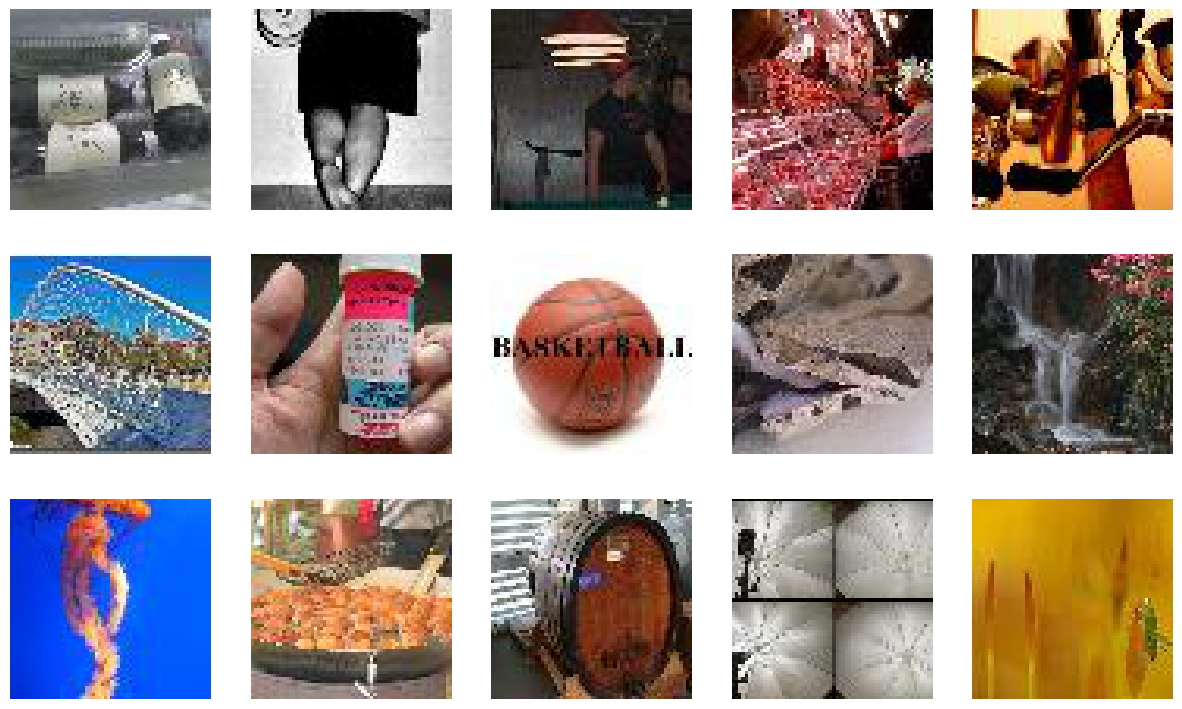

In [15]:
show_images(xb[0:15])

In [16]:
xb.shape

torch.Size([32, 3, 64, 64])

### CLIP: (img, text) -> (img_emb, text_emb)

In [17]:
inputs = processor(text=captions, images=xb, return_tensors="pt", padding=True, do_rescale=False)
image_input = inputs["pixel_values"].to("cuda")
text_inputs = inputs["input_ids"].to("cuda")
attention_mask = inputs["attention_mask"].to("cuda")

In [18]:
with torch.no_grad():
    # Compute the image and text embeddings
    image_features = model.get_image_features(image_input)
    text_features = model.get_text_features(input_ids=text_inputs, attention_mask=attention_mask)

In [19]:
image_features.shape, text_features.shape

(torch.Size([32, 768]), torch.Size([200, 768]))

In [20]:
# Normalize the features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

### Pass img_features to SD training

In [21]:
#| export
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl])

Info: In order to fix some CUDA multiprocessing issue which I don't understand. Please set num_workers=0 as shown in the cell below. Source: https://github.com/pytorch/pytorch/issues/40403#issuecomment-731782611

In [22]:
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=0)

TODO: Double check if the transformi shown below was implemented correctly within collate_ddpm()

def transformi(b): b[xl] = [F.pad( (torch.ones([3,1,1])*TF.to_tensor(o))  , (2,2,2,2))-0.5 for o in b[xl]]

In [23]:
def collate_ddpm(b):
    #import pdb; pdb.set_trace()    
    b = default_collate(b)
    #(xt,t),eps = noisify(b[xl])       # original line from Jeremy
    
    # ok, let's do the padding and shifting the range from (0,1) to (-0.5,0.5) for SD
    b_padded_n_shifted = F.pad(b[xl], (2,2,2,2))-0.5
    (xt,t),eps = noisify(b_padded_n_shifted)
    
    # Below are lines for CLIP
    inputs = processor(images=b[xl], return_tensors="pt", padding=True, do_rescale=False).to("cuda")
    image_input = inputs["pixel_values"]
    with torch.no_grad():
        image_features = model.get_image_features(image_input)
    return (xt,t,image_features),eps

In [24]:
@inplace
def transformi(b): b[xl] = [ (torch.ones([3,1,1])*TF.to_tensor(o)) for o in b[xl]]

In [25]:
tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['valid']))

dl = dls.train

In [26]:
%%time
(xt,t,image_features),eps = b = next(iter(dl))

CPU times: user 907 ms, sys: 54.8 ms, total: 962 ms
Wall time: 161 ms


In [27]:
xt.shape, t.shape, image_features.shape, eps.shape

(torch.Size([32, 3, 68, 68]),
 torch.Size([32]),
 torch.Size([32, 768]),
 torch.Size([32, 3, 68, 68]))

In [28]:
t[0]

tensor(0.2168)

In [29]:
xt[0].shape

torch.Size([3, 68, 68])

In [30]:
eps[0].shape

torch.Size([3, 68, 68])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


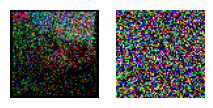

In [31]:
show_images(torch.cat([ xt[0][None,:,:,:], eps[0][None,:,:,:]  ]), figsize=(2.5,2.5))

In [32]:
torch.mean(xt), torch.std(xt)

(tensor(-0.0940), tensor(0.7588))